# Hamilton-Jacobi Reachibility

In the following we will analyse the Hamilton-Jacobi Reachibility for a 1-dimensional coupled space, with state $\vec{x}$ and dynamics $\frac{d}{dt} \vec{x}$: 

\begin{equation}
\vec{x} = \begin{pmatrix}x\\v_x\end{pmatrix} = \begin{pmatrix}x_{robot} - x_{pedestrian}\\v_x\end{pmatrix}
\end{equation}

\begin{equation}
\frac{d}{dt}\vec{x} = \begin{pmatrix}v_x - d\\u\end{pmatrix}
\end{equation}

with $u$ being the control input applied by the robot and $d$ the disturbance, the pedestrian with single integrator dynamics. In order to be provably safe we look for the tube in that the robot's state must be in at every point in time so that no matter what the pedestrian does they both will not collide (collision is modelled here as being less or equal than one meter apart from each other).

The Hamilton-Jacobi Reachibility computes the values of a min-max game, in which the robot chooses its actions in order to avoid some set (here a tube around $\Delta x = 0$) as best as possible while the the disturbance does the oppositie, i.e. the disturbance (aka the pedestrian) tries to push the system in the avoid set. 

In [7]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
from IPython.display import HTML
import seaborn as sns

In [2]:
import numpy as np
import torch

from mantrap.agents import DoubleIntegratorDTAgent
from mantrap.environment import PotentialFieldEnvironment
from mantrap.modules import HJReachabilityModule
from mantrap.solver import SGradSolver


env = PotentialFieldEnvironment(DoubleIntegratorDTAgent, ego_position=torch.zeros(2), dt=0.4)
env.add_ado(position=torch.tensor([8, 0]), num_modes=1)
env.add_ado(position=torch.tensor([-8, 0]), num_modes=1)

module = HJReachabilityModule(env=env, t_horizon=3, weight=1.0)

### Value Function and Gradient Plot (2D slices)

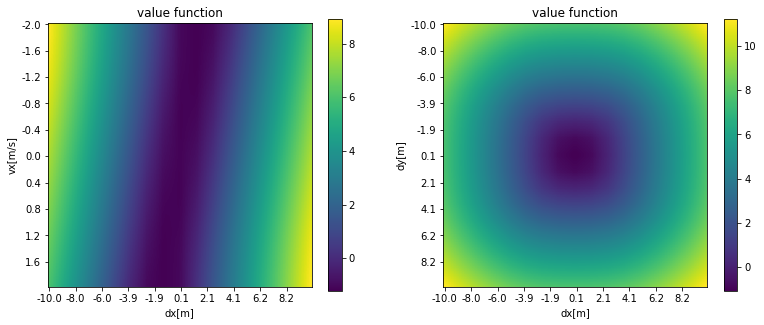

In [3]:
N = 100

plt.close('all')
fig = plt.figure(figsize=(13, 5))
ticks = np.arange(0, N, step=N//10)

# Draw x-vx two-dimensional slice of value function at y = vy = 0.
x_linspace = np.linspace(*env.x_axis, num=N)
v_linspace = np.linspace(*env.ego.speed_limits, num=N)
x_grid, v_grid = np.meshgrid(x_linspace, v_linspace)
x_grid = x_grid.flatten()
v_grid = v_grid.flatten()
xyv_grid = np.stack((x_grid, np.zeros(N**2), v_grid, np.zeros(N**2))).T
value_function = module.value_function(xyv_grid)

plt.subplot(1, 2, 1)
im = plt.imshow(value_function.reshape(N, N))
plt.xlabel("dx[m]")
plt.ylabel("vx[m/s]")
plt.xticks(ticks, np.round(x_linspace, 1)[ticks])
plt.yticks(ticks, np.round(v_linspace, 1)[ticks])
plt.title("value function")
plt.colorbar(im)

# Draw x-y two-dimensional slice of value function at vx = vy = 0.
y_linspace = np.linspace(*env.y_axis, num=N)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
x_grid = x_grid.flatten()
y_grid = y_grid.flatten()
xyv_grid = np.stack((x_grid, y_grid, np.zeros(N**2), np.zeros(N**2))).T
value_function = module.value_function(xyv_grid)

plt.subplot(1, 2, 2)
im = plt.imshow(value_function.reshape(N, N))
plt.xlabel("dx[m]")
plt.ylabel("dy[m]")
plt.xticks(ticks, np.round(x_linspace, 1)[ticks])
plt.yticks(ticks, np.round(y_linspace, 1)[ticks])
plt.title("value function")
plt.colorbar(im)

plt.show()

### HJ-Constraint in Optimization

In [4]:
env = PotentialFieldEnvironment(DoubleIntegratorDTAgent, ego_position=torch.zeros(2), dt=0.4)
env.add_ado(position=torch.tensor([3, 0]), num_modes=1)
env.add_ado(position=torch.tensor([-3, 0]), num_modes=1)

solver = SGradSolver(env, goal=torch.rand(2), t_planning=3, modules=[HJReachabilityModule])
HTML(solver.visualize_heat_map(propagation="constant"))

### Value Function Approximation 

In [ ]:
import os

import mantrap
import numpy as np
import pandas as pd
import torch

t_horizon = 5

env = mantrap.environment.Trajectron(mantrap.agents.DoubleIntegratorDTAgent, 
                                     ego_position=torch.zeros(2))
_  = env.add_ado(position=torch.rand(2) * 4, velocity=torch.rand(2))

In [ ]:
file_baseline = "2D_large.mat"
module_baseline = mantrap.modules.HJReachabilityModule(env, t_horizon=t_horizon, data_file=file_baseline)

# Loading accuartely computed value function and compute meshgrid containing every computed grid coordinate.
_, _, grid_size_by_dim, _, (grid_min, grid_max) = mantrap.modules.HJReachabilityModule.unpack_mat_file(
    mat_file_path=os.path.join(mantrap.utility.io.build_os_path("third_party/reachability"), file_baseline)
)
x_grid, y_grid, vx_grid, vy_grid = np.meshgrid(*(np.linspace(grid_min[i], grid_max[i], num=grid_size_by_dim[i]) \
                                                 for i in range(4)))
mesh = np.stack((x_grid.flatten(), y_grid.flatten(), vx_grid.flatten(), vy_grid.flatten())).T

# In order to reduce the number of evaluation points, sample 1000 random points.
idx = np.random.randint(low=0, high=mesh.shape[0] - 1, size=1000)
mesh = mesh[idx, :]
print(f"Meshgrid with {mesh.shape[0]} elements ready for evaluation !")

In [ ]:
# Evaluate value function error of approximation.
models = {"small": "2D_small.mat", "interior": "2D_interior.mat", "medium": "2D_medium.mat"}

results_df = pd.DataFrame(columns=["model", "error", "x", "y", "vx", "vy"])
for label, file_name in models.items():
    print(label, file_name)
    module = mantrap.modules.HJReachabilityModule(env, t_horizon=t_horizon, data_file=file_name)
    
    for x_rel in mesh:
        error = module.value_function(x_rel) - module_baseline.value_function(x_rel)
        results_df = results_df.append({"model": label, "error": float(error), 
                                        "x": x_rel[0], "y": x_rel[1], "vx": x_rel[2], "vy": x_rel[3]}, 
                                        ignore_index=True)

In [ ]:
results_df["log_error"] = np.log(np.abs(results_df["error"]) + 1e-10)  # avoiding nan values (log(0)/log(-x))
results_df

In [ ]:
# Plot results as bar plot.
ax = sns.boxplot(x="log_error", y="model", data=results_df)
plt.show()

In [ ]:
ax = sns.pairplot(data=results_df, hue="model", y_vars=["error"], x_vars=["x", "y", "vx", "vy"], diag_kind="kde")
plt.show()

ax = sns.pairplot(data=results_df, hue="model", y_vars=["error"], x_vars=["x", "y", "vx", "vy"], diag_kind="kde")
plt.show()

In [2]:
import os

import mantrap
import numpy as np
import pandas as pd
import torch

t_horizon = 5

env = mantrap.environment.Trajectron(mantrap.agents.DoubleIntegratorDTAgent, 
                                     ego_position=torch.zeros(2))
_  = env.add_ado(position=torch.rand(2) * 4, velocity=torch.rand(2))

In [3]:
file_baseline = "2D_large.mat"
module_baseline = mantrap.modules.HJReachabilityModule(env, t_horizon=t_horizon, data_file=file_baseline)

# Loading accuartely computed value function and compute meshgrid containing every computed grid coordinate.
_, _, grid_size_by_dim, _, (grid_min, grid_max) = mantrap.modules.HJReachabilityModule.unpack_mat_file(
    mat_file_path=os.path.join(mantrap.utility.io.build_os_path("third_party/reachability"), file_baseline)
)
x_grid, y_grid, vx_grid, vy_grid = np.meshgrid(*(np.linspace(grid_min[i], grid_max[i], num=grid_size_by_dim[i]) \
                                                 for i in range(4)))
mesh = np.stack((x_grid.flatten(), y_grid.flatten(), vx_grid.flatten(), vy_grid.flatten())).T

# In order to reduce the number of evaluation points, sample 1000 random points.
idx = np.random.randint(low=0, high=mesh.shape[0] - 1, size=1000)
mesh = mesh[idx, :]
print(f"Meshgrid with {mesh.shape[0]} elements ready for evaluation !")

Meshgrid with 1000 elements ready for evaluation !


In [4]:
# Evaluate value function error of approximation.
models = {"small": "2D_small.mat", "interior": "2D_interior.mat", "medium": "2D_medium.mat"}

results_df = pd.DataFrame(columns=["model", "error", "x", "y", "vx", "vy"])
for label, file_name in models.items():
    print(label, file_name)
    module = mantrap.modules.HJReachabilityModule(env, t_horizon=t_horizon, data_file=file_name)
    
    for x_rel in mesh:
        error = module.value_function(x_rel) - module_baseline.value_function(x_rel)
        results_df = results_df.append({"model": label, "error": float(error), 
                                        "x": x_rel[0], "y": x_rel[1], "vx": x_rel[2], "vy": x_rel[3]}, 
                                        ignore_index=True)

small 2D_small.mat
interior 2D_interior.mat
medium 2D_medium.mat


In [5]:
results_df["log_error"] = np.log(np.abs(results_df["error"]) + 1e-10)  # avoiding nan values (log(0)/log(-x))
results_df

,model,error,x,y,vx,vy,log_error
0,small,0.119561,-4.5,-24.0,1.5,-0.5,-2.123932
1,small,2.141991,3.0,1.5,-1.8,-2.0,0.761736
2,small,0.060316,-22.5,18.0,0.9,1.8,-2.808151
3,small,0.145727,30.0,-10.5,-1.6,-0.2,-1.926019
4,small,0.283705,9.0,18.0,-1.3,-1.8,-1.259819
...,...,...,...,...,...,...,...
2995,medium,-0.002578,-15.0,-27.0,-2.0,1.6,-5.960809
2996,medium,0.017864,22.5,30.0,1.9,1.7,-4.024951
2997,medium,0.025322,-9.0,13.5,1.0,1.4,-3.676078
2998,medium,0.039885,16.5,-28.5,-0.6,-1.1,-3.221748


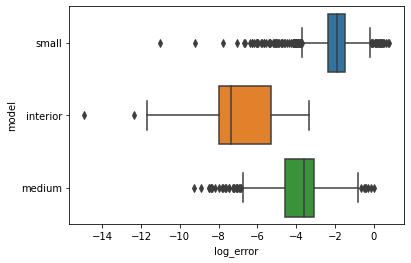

In [8]:
# Plot results as bar plot.
ax = sns.boxplot(x="log_error", y="model", data=results_df)
plt.show()

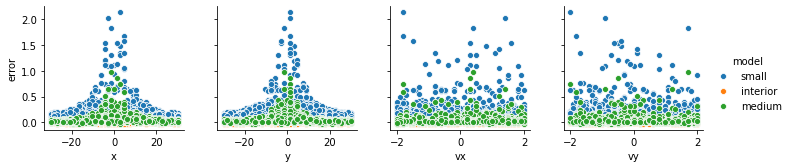

In [9]:
ax = sns.pairplot(data=results_df, hue="model", y_vars=["error"], x_vars=["x", "y", "vx", "vy"], diag_kind="kde")
plt.show()